# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import get_symbols, construct_data_and_labels, select_circuits, read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc, visualize_result_noisyopt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

EPOCHS = 1000
SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np
rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Lambeq optimizer

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

Progress:  0.022
Number of training circuits: 10    Number of validation circuits: 45    Number of test circuits: 42    Number of parameters in model: 161


Epoch: 100    train/loss: 0.4607999920845032    valid/loss: 0.6654999852180481    train/acc: 0.7999999523162842    valid/acc: 0.5777999758720398
Epoch: 200    train/loss: 0.35189998149871826    valid/loss: 0.6488999724388123    train/acc: 0.8999999761581421    valid/acc: 0.5555999875068665
Epoch: 300    train/loss: 0.2929999828338623    valid/loss: 0.644599974155426    train/acc: 1.0    valid/acc: 0.5555999875068665
Epoch: 400    train/loss: 0.30219998955726624    valid/loss: 0.6333000063896179    train/acc: 0.8999999761581421    valid/acc: 0.53329998254776
Epoch: 500    train/loss: 0.3146999776363373    valid/loss: 0.6265999674797058    train/acc: 0.8999999761581421    valid/acc: 0.5777999758720398
Epoch: 600    train/loss: 0.3287000060081482    valid/loss: 0.6353999972343445    train/acc: 0.8999999761581421    valid/acc: 0.5777999758720398
Epoch: 700    train/loss: 0.37359997630119324    valid/loss: 0.6349999904632568    train/acc: 0.7999999523162842    valid/acc: 0.5777999758720398


Test accuracy: 0.61904764
Progress:  0.025
Number of training circuits: 11    Number of validation circuits: 47    Number of test circuits: 46    Number of parameters in model: 173


Epoch: 100    train/loss: 0.34369999170303345    valid/loss: 0.6679999828338623    train/acc: 0.9090999960899353    valid/acc: 0.5744999647140503
Epoch: 200    train/loss: 0.2703999876976013    valid/loss: 0.6547999978065491    train/acc: 1.0    valid/acc: 0.5744999647140503
Epoch: 300    train/loss: 0.2732999920845032    valid/loss: 0.6570000052452087    train/acc: 1.0    valid/acc: 0.5744999647140503
Epoch: 400    train/loss: 0.26589998602867126    valid/loss: 0.6574999690055847    train/acc: 1.0    valid/acc: 0.5744999647140503
Epoch: 500    train/loss: 0.26190000772476196    valid/loss: 0.6574999690055847    train/acc: 1.0    valid/acc: 0.5744999647140503
Epoch: 600    train/loss: 0.2856000065803528    valid/loss: 0.660099983215332    train/acc: 0.9090999960899353    valid/acc: 0.5744999647140503
Epoch: 700    train/loss: 0.2507999837398529    valid/loss: 0.663100004196167    train/acc: 1.0    valid/acc: 0.5744999647140503
Epoch: 800    train/loss: 0.2223999947309494    valid/loss:

Test accuracy: 0.5652174
Progress:  0.027
Progress:  0.029
Progress:  0.031
Number of training circuits: 13    Number of validation circuits: 53    Number of test circuits: 52    Number of parameters in model: 190


Epoch: 100    train/loss: 0.2612999975681305    valid/loss: 0.7402999997138977    train/acc: 1.0    valid/acc: 0.6037999987602234
Epoch: 200    train/loss: 0.23389999568462372    valid/loss: 0.7428999543190002    train/acc: 1.0    valid/acc: 0.5848999619483948
Epoch: 300    train/loss: 0.26350000500679016    valid/loss: 0.7369999885559082    train/acc: 1.0    valid/acc: 0.6037999987602234
Epoch: 400    train/loss: 0.2662999927997589    valid/loss: 0.7436999678611755    train/acc: 0.9230999946594238    valid/acc: 0.6037999987602234
Epoch: 500    train/loss: 0.20509999990463257    valid/loss: 0.7547000050544739    train/acc: 1.0    valid/acc: 0.6037999987602234
Epoch: 600    train/loss: 0.22939999401569366    valid/loss: 0.7608999609947205    train/acc: 1.0    valid/acc: 0.6037999987602234
Epoch: 700    train/loss: 0.2328999936580658    valid/loss: 0.7656999826431274    train/acc: 1.0    valid/acc: 0.6037999987602234
Epoch: 800    train/loss: 0.23229999840259552    valid/loss: 0.76370000

Test accuracy: 0.5769231
Progress:  0.033
Number of training circuits: 14    Number of validation circuits: 70    Number of test circuits: 64    Number of parameters in model: 193


Epoch: 100    train/loss: 0.3111000061035156    valid/loss: 0.7116999626159668    train/acc: 0.9285999536514282    valid/acc: 0.5856999754905701
Epoch: 200    train/loss: 0.33730000257492065    valid/loss: 0.7149999737739563    train/acc: 0.8570999503135681    valid/acc: 0.5428999662399292
Epoch: 300    train/loss: 0.25619998574256897    valid/loss: 0.7276999950408936    train/acc: 0.9285999536514282    valid/acc: 0.5285999774932861
Epoch: 400    train/loss: 0.202799990773201    valid/loss: 0.7170999646186829    train/acc: 1.0    valid/acc: 0.5428999662399292
Epoch: 500    train/loss: 0.19679999351501465    valid/loss: 0.6995999813079834    train/acc: 1.0    valid/acc: 0.571399986743927
Epoch: 600    train/loss: 0.16030000150203705    valid/loss: 0.6940999627113342    train/acc: 1.0    valid/acc: 0.5856999754905701
Epoch: 700    train/loss: 0.1394999921321869    valid/loss: 0.6861000061035156    train/acc: 1.0    valid/acc: 0.5856999754905701
Epoch: 800    train/loss: 0.137599989771842

Test accuracy: 0.625
Progress:  0.036
Progress:  0.038
Number of training circuits: 16    Number of validation circuits: 73    Number of test circuits: 67    Number of parameters in model: 196


Epoch: 100    train/loss: 0.36969998478889465    valid/loss: 0.6883999705314636    train/acc: 0.875    valid/acc: 0.5752999782562256
Epoch: 200    train/loss: 0.28769999742507935    valid/loss: 0.699999988079071    train/acc: 0.9375    valid/acc: 0.6026999950408936
Epoch: 300    train/loss: 0.3296000063419342    valid/loss: 0.7188000082969666    train/acc: 0.9375    valid/acc: 0.6026999950408936
Epoch: 400    train/loss: 0.28839999437332153    valid/loss: 0.7274999618530273    train/acc: 0.9375    valid/acc: 0.5752999782562256
Epoch: 500    train/loss: 0.28450000286102295    valid/loss: 0.7321999669075012    train/acc: 0.9375    valid/acc: 0.5889999866485596
Epoch: 600    train/loss: 0.26010000705718994    valid/loss: 0.7387999892234802    train/acc: 0.9375    valid/acc: 0.5752999782562256
Epoch: 700    train/loss: 0.287200003862381    valid/loss: 0.7422999739646912    train/acc: 0.9375    valid/acc: 0.5615999698638916
Epoch: 800    train/loss: 0.3050999939441681    valid/loss: 0.74559

Test accuracy: 0.5820896
Progress:  0.04
Progress:  0.042
Number of training circuits: 18    Number of validation circuits: 85    Number of test circuits: 74    Number of parameters in model: 199


Epoch: 100    train/loss: 0.31459999084472656    valid/loss: 0.8102999925613403    train/acc: 0.9443999528884888    valid/acc: 0.5647000074386597
Epoch: 200    train/loss: 0.24409998953342438    valid/loss: 0.7890999913215637    train/acc: 0.9443999528884888    valid/acc: 0.5411999821662903
Epoch: 300    train/loss: 0.28769999742507935    valid/loss: 0.7968999743461609    train/acc: 0.9443999528884888    valid/acc: 0.5647000074386597
Epoch: 400    train/loss: 0.28859999775886536    valid/loss: 0.8039999604225159    train/acc: 0.9443999528884888    valid/acc: 0.552899956703186
Epoch: 500    train/loss: 0.2768000066280365    valid/loss: 0.8052999973297119    train/acc: 0.9443999528884888    valid/acc: 0.5411999821662903
Epoch: 600    train/loss: 0.3270999789237976    valid/loss: 0.8132999539375305    train/acc: 0.8888999819755554    valid/acc: 0.5411999821662903
Epoch: 700    train/loss: 0.27140000462532043    valid/loss: 0.8127999901771545    train/acc: 0.9443999528884888    valid/acc: 

Test accuracy: 0.58108103
Progress:  0.045
Number of training circuits: 19    Number of validation circuits: 87    Number of test circuits: 78    Number of parameters in model: 205


Epoch: 100    train/loss: 0.31290000677108765    valid/loss: 0.7835999727249146    train/acc: 0.9473999738693237    valid/acc: 0.5631999969482422
Epoch: 200    train/loss: 0.27730000019073486    valid/loss: 0.7940999865531921    train/acc: 0.9473999738693237    valid/acc: 0.5631999969482422
Epoch: 300    train/loss: 0.3024999797344208    valid/loss: 0.8007999658584595    train/acc: 0.9473999738693237    valid/acc: 0.5516999959945679
Epoch: 400    train/loss: 0.26429998874664307    valid/loss: 0.8026999831199646    train/acc: 0.9473999738693237    valid/acc: 0.5401999950408936
Epoch: 500    train/loss: 0.29440000653266907    valid/loss: 0.7996999621391296    train/acc: 0.9473999738693237    valid/acc: 0.5631999969482422
Epoch: 600    train/loss: 0.2457999885082245    valid/loss: 0.79749995470047    train/acc: 0.9473999738693237    valid/acc: 0.5631999969482422
Epoch: 700    train/loss: 0.31599998474121094    valid/loss: 0.8007999658584595    train/acc: 0.9473999738693237    valid/acc: 0

Test accuracy: 0.64102566
Progress:  0.047
Number of training circuits: 20    Number of validation circuits: 87    Number of test circuits: 81    Number of parameters in model: 208


Epoch: 100    train/loss: 0.2865999937057495    valid/loss: 0.7680999636650085    train/acc: 0.949999988079071    valid/acc: 0.5401999950408936
Epoch: 200    train/loss: 0.3091000020503998    valid/loss: 0.7698999643325806    train/acc: 0.8999999761581421    valid/acc: 0.5171999931335449
Epoch: 300    train/loss: 0.25859999656677246    valid/loss: 0.7727999687194824    train/acc: 0.949999988079071    valid/acc: 0.5171999931335449
Epoch: 400    train/loss: 0.23919999599456787    valid/loss: 0.7705999612808228    train/acc: 0.949999988079071    valid/acc: 0.5056999921798706
Epoch: 500    train/loss: 0.24329999089241028    valid/loss: 0.7701999545097351    train/acc: 0.949999988079071    valid/acc: 0.5171999931335449
Epoch: 600    train/loss: 0.24719999730587006    valid/loss: 0.7726999521255493    train/acc: 0.949999988079071    valid/acc: 0.5171999931335449
Epoch: 700    train/loss: 0.22029998898506165    valid/loss: 0.7714999914169312    train/acc: 0.949999988079071    valid/acc: 0.528

Test accuracy: 0.61728394
Progress:  0.049
Number of training circuits: 21    Number of validation circuits: 87    Number of test circuits: 84    Number of parameters in model: 211


Epoch: 100    train/loss: 0.25270000100135803    valid/loss: 0.7745999693870544    train/acc: 0.9523999691009521    valid/acc: 0.5286999940872192
Epoch: 200    train/loss: 0.23759999871253967    valid/loss: 0.7694000005722046    train/acc: 0.9523999691009521    valid/acc: 0.5056999921798706
Epoch: 300    train/loss: 0.22709999978542328    valid/loss: 0.7652999758720398    train/acc: 0.9523999691009521    valid/acc: 0.5171999931335449
Epoch: 400    train/loss: 0.24819999933242798    valid/loss: 0.7683999538421631    train/acc: 0.9523999691009521    valid/acc: 0.5171999931335449
Epoch: 500    train/loss: 0.27399998903274536    valid/loss: 0.7680999636650085    train/acc: 0.9523999691009521    valid/acc: 0.5171999931335449
Epoch: 600    train/loss: 0.20509999990463257    valid/loss: 0.7692999839782715    train/acc: 0.9523999691009521    valid/acc: 0.5171999931335449
Epoch: 700    train/loss: 0.23109999299049377    valid/loss: 0.7671999931335449    train/acc: 0.9523999691009521    valid/ac

Test accuracy: 0.5714286
Progress:  0.051
Progress:  0.054
Progress:  0.056
Progress:  0.058
Progress:  0.06
Number of training circuits: 26    Number of validation circuits: 90    Number of test circuits: 89    Number of parameters in model: 214


Epoch: 100    train/loss: 0.30480000376701355    valid/loss: 0.8157999515533447    train/acc: 0.9614999890327454    valid/acc: 0.53329998254776
Epoch: 200    train/loss: 0.2287999987602234    valid/loss: 0.8616999983787537    train/acc: 1.0    valid/acc: 0.5110999941825867
Epoch: 300    train/loss: 0.211899995803833    valid/loss: 0.840499997138977    train/acc: 1.0    valid/acc: 0.5110999941825867
Epoch: 400    train/loss: 0.2003999948501587    valid/loss: 0.8432999849319458    train/acc: 1.0    valid/acc: 0.5221999883651733
Epoch: 500    train/loss: 0.21239998936653137    valid/loss: 0.8405999541282654    train/acc: 1.0    valid/acc: 0.53329998254776
Epoch: 600    train/loss: 0.19609999656677246    valid/loss: 0.8423999547958374    train/acc: 1.0    valid/acc: 0.5555999875068665
Epoch: 700    train/loss: 0.19409999251365662    valid/loss: 0.8391000032424927    train/acc: 1.0    valid/acc: 0.5777999758720398
Epoch: 800    train/loss: 0.18299999833106995    valid/loss: 0.83949995040893

Test accuracy: 0.66292137
Progress:  0.062
Number of training circuits: 27    Number of validation circuits: 93    Number of test circuits: 90    Number of parameters in model: 217


Epoch: 100    train/loss: 0.23279999196529388    valid/loss: 0.8405999541282654    train/acc: 0.9629999995231628    valid/acc: 0.5483999848365784
Epoch: 200    train/loss: 0.21709999442100525    valid/loss: 0.8495999574661255    train/acc: 0.9258999824523926    valid/acc: 0.5483999848365784
Epoch: 300    train/loss: 0.2256999909877777    valid/loss: 0.8556999564170837    train/acc: 0.9629999995231628    valid/acc: 0.5483999848365784
Epoch: 400    train/loss: 0.22029998898506165    valid/loss: 0.8502999544143677    train/acc: 0.9258999824523926    valid/acc: 0.5483999848365784
Epoch: 500    train/loss: 0.1939999908208847    valid/loss: 0.8554999828338623    train/acc: 0.9629999995231628    valid/acc: 0.5483999848365784
Epoch: 600    train/loss: 0.19280000030994415    valid/loss: 0.8517999649047852    train/acc: 0.9629999995231628    valid/acc: 0.5590999722480774
Epoch: 700    train/loss: 0.19299998879432678    valid/loss: 0.8513000011444092    train/acc: 1.0    valid/acc: 0.559099972248

Test accuracy: 0.7
Progress:  0.065
Progress:  0.067
Progress:  0.069
Number of training circuits: 30    Number of validation circuits: 96    Number of test circuits: 92    Number of parameters in model: 223


Epoch: 100    train/loss: 0.28209999203681946    valid/loss: 0.8411999940872192    train/acc: 0.9666999578475952    valid/acc: 0.5728999972343445
Epoch: 200    train/loss: 0.19489999115467072    valid/loss: 0.8325999975204468    train/acc: 0.9332999587059021    valid/acc: 0.5521000027656555
Epoch: 300    train/loss: 0.1834999918937683    valid/loss: 0.8321999907493591    train/acc: 1.0    valid/acc: 0.5521000027656555
Epoch: 400    train/loss: 0.22709999978542328    valid/loss: 0.843999981880188    train/acc: 0.9666999578475952    valid/acc: 0.5521000027656555
Epoch: 500    train/loss: 0.21789999306201935    valid/loss: 0.8481000065803528    train/acc: 0.9666999578475952    valid/acc: 0.5521000027656555
Epoch: 600    train/loss: 0.1946999877691269    valid/loss: 0.8628000020980835    train/acc: 1.0    valid/acc: 0.5521000027656555
Epoch: 700    train/loss: 0.17189998924732208    valid/loss: 0.8554999828338623    train/acc: 0.9666999578475952    valid/acc: 0.5521000027656555
Epoch: 800 

Test accuracy: 0.7173913
Progress:  0.071
Progress:  0.074
Progress:  0.076
Progress:  0.078
Progress:  0.08
Number of training circuits: 35    Number of validation circuits: 97    Number of test circuits: 96    Number of parameters in model: 229


Epoch: 100    train/loss: 0.2142999917268753    valid/loss: 0.8547999858856201    train/acc: 0.9429000020027161    valid/acc: 0.5669999718666077
Epoch: 200    train/loss: 0.22289998829364777    valid/loss: 0.8721999526023865    train/acc: 0.885699987411499    valid/acc: 0.5669999718666077
Epoch: 300    train/loss: 0.24479998648166656    valid/loss: 0.8770999908447266    train/acc: 0.9142999649047852    valid/acc: 0.5669999718666077
Epoch: 400    train/loss: 0.21139998733997345    valid/loss: 0.8711999654769897    train/acc: 0.9429000020027161    valid/acc: 0.5566999912261963
Epoch: 500    train/loss: 0.2386000007390976    valid/loss: 0.8718000054359436    train/acc: 0.9713999629020691    valid/acc: 0.5566999912261963
Epoch: 600    train/loss: 0.20430000126361847    valid/loss: 0.8673999905586243    train/acc: 0.9713999629020691    valid/acc: 0.5566999912261963
Epoch: 700    train/loss: 0.20489999651908875    valid/loss: 0.8691999912261963    train/acc: 0.9713999629020691    valid/acc: 

Test accuracy: 0.71875
Progress:  0.083
Progress:  0.085
Progress:  0.087
Progress:  0.089
Number of training circuits: 39    Number of validation circuits: 101    Number of test circuits: 101    Number of parameters in model: 232


Epoch: 100    train/loss: 0.23420000076293945    valid/loss: 0.814300000667572    train/acc: 0.974399983882904    valid/acc: 0.5742999911308289
Epoch: 200    train/loss: 0.22869999706745148    valid/loss: 0.8125    train/acc: 0.974399983882904    valid/acc: 0.5742999911308289
Epoch: 300    train/loss: 0.23669999837875366    valid/loss: 0.816100001335144    train/acc: 0.974399983882904    valid/acc: 0.5643999576568604
Epoch: 400    train/loss: 0.20979999005794525    valid/loss: 0.8114999532699585    train/acc: 0.974399983882904    valid/acc: 0.5643999576568604
Epoch: 500    train/loss: 0.20960000157356262    valid/loss: 0.8108999729156494    train/acc: 0.974399983882904    valid/acc: 0.5643999576568604
Epoch: 600    train/loss: 0.23079998791217804    valid/loss: 0.8093999624252319    train/acc: 0.974399983882904    valid/acc: 0.5643999576568604
Epoch: 700    train/loss: 0.21819999814033508    valid/loss: 0.8116999864578247    train/acc: 1.0    valid/acc: 0.5643999576568604
Epoch: 800   

Test accuracy: 0.6930693
Progress:  0.092
Number of training circuits: 40    Number of validation circuits: 104    Number of test circuits: 104    Number of parameters in model: 235


Epoch: 100    train/loss: 0.258899986743927    valid/loss: 0.8263999819755554    train/acc: 0.9249999523162842    valid/acc: 0.5385000109672546
Epoch: 200    train/loss: 0.25130000710487366    valid/loss: 0.8215999603271484    train/acc: 0.949999988079071    valid/acc: 0.557699978351593
Epoch: 300    train/loss: 0.2565000057220459    valid/loss: 0.8226999640464783    train/acc: 0.949999988079071    valid/acc: 0.5480999946594238
Epoch: 400    train/loss: 0.24249999225139618    valid/loss: 0.8150999546051025    train/acc: 0.949999988079071    valid/acc: 0.557699978351593
Epoch: 500    train/loss: 0.24139998853206635    valid/loss: 0.8118999600410461    train/acc: 0.949999988079071    valid/acc: 0.557699978351593
Epoch: 600    train/loss: 0.23189999163150787    valid/loss: 0.8112999796867371    train/acc: 0.9249999523162842    valid/acc: 0.557699978351593
Epoch: 700    train/loss: 0.21899999678134918    valid/loss: 0.8097999691963196    train/acc: 0.949999988079071    valid/acc: 0.5672999

Test accuracy: 0.6923077
Progress:  0.094
Progress:  0.096
Progress:  0.098
Progress:  0.1
Progress:  0.103
Progress:  0.105
Progress:  0.107
Progress:  0.109
Progress:  0.112
Progress:  0.114
Progress:  0.116
Progress:  0.118
Progress:  0.121
Progress:  0.123
Progress:  0.125
Progress:  0.127
Progress:  0.129
Progress:  0.132
Number of training circuits: 58    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 238


Epoch: 100    train/loss: 0.3330000042915344    valid/loss: 0.7975999712944031    train/acc: 0.8792999982833862    valid/acc: 0.5925999879837036
Epoch: 200    train/loss: 0.3416999876499176    valid/loss: 0.792199969291687    train/acc: 0.8621000051498413    valid/acc: 0.6110999584197998
Epoch: 300    train/loss: 0.32349997758865356    valid/loss: 0.7949999570846558    train/acc: 0.8792999982833862    valid/acc: 0.6204000115394592
Epoch: 400    train/loss: 0.3154999911785126    valid/loss: 0.7997999787330627    train/acc: 0.8621000051498413    valid/acc: 0.6110999584197998
Epoch: 500    train/loss: 0.3084999918937683    valid/loss: 0.7944999933242798    train/acc: 0.8965999484062195    valid/acc: 0.6204000115394592
Epoch: 600    train/loss: 0.2946999967098236    valid/loss: 0.8190999627113342    train/acc: 0.8965999484062195    valid/acc: 0.6204000115394592
Epoch: 700    train/loss: 0.3050000071525574    valid/loss: 0.8083999752998352    train/acc: 0.8792999982833862    valid/acc: 0.62

Test accuracy: 0.6944445
Progress:  0.134
Progress:  0.136
Progress:  0.138
Progress:  0.141
Progress:  0.143
Progress:  0.145
Progress:  0.147
Progress:  0.15
Progress:  0.152
Progress:  0.154
Progress:  0.156
Progress:  0.158
Progress:  0.161
Progress:  0.163
Progress:  0.165
Progress:  0.167
Progress:  0.17
Progress:  0.172
Progress:  0.174
Progress:  0.176
Progress:  0.179
Progress:  0.181
Progress:  0.183
Progress:  0.185
Progress:  0.188
Progress:  0.19
Progress:  0.192
Progress:  0.194
Progress:  0.196
Progress:  0.199
Progress:  0.201
Progress:  0.203
Progress:  0.205
Progress:  0.208
Progress:  0.21
Progress:  0.212
Progress:  0.214
Progress:  0.217
Progress:  0.219
Progress:  0.221
Progress:  0.223
Progress:  0.225
Progress:  0.228
Number of training circuits: 101    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 241


Epoch: 100    train/loss: 0.43619999289512634    valid/loss: 0.7658999562263489    train/acc: 0.8118999600410461    valid/acc: 0.5925999879837036
Epoch: 200    train/loss: 0.44269999861717224    valid/loss: 0.7628999948501587    train/acc: 0.7920999526977539    valid/acc: 0.6018999814987183
Epoch: 300    train/loss: 0.43149998784065247    valid/loss: 0.7537999749183655    train/acc: 0.8118999600410461    valid/acc: 0.6110999584197998
Epoch: 400    train/loss: 0.4197999835014343    valid/loss: 0.7547999620437622    train/acc: 0.8217999935150146    valid/acc: 0.6110999584197998
Epoch: 500    train/loss: 0.3959999978542328    valid/loss: 0.753600001335144    train/acc: 0.8118999600410461    valid/acc: 0.6204000115394592
Epoch: 600    train/loss: 0.4193999767303467    valid/loss: 0.7601000070571899    train/acc: 0.8316999673843384    valid/acc: 0.6110999584197998
Epoch: 700    train/loss: 0.4056999981403351    valid/loss: 0.7548999786376953    train/acc: 0.8316999673843384    valid/acc: 0.

Test accuracy: 0.712963
Progress:  0.23
Progress:  0.232
Progress:  0.234
Progress:  0.237
Progress:  0.239
Progress:  0.241
Progress:  0.243
Progress:  0.246
Progress:  0.248
Progress:  0.25
Progress:  0.252
Progress:  0.254
Progress:  0.257
Progress:  0.259
Progress:  0.261
Progress:  0.263
Progress:  0.266
Progress:  0.268
Progress:  0.27
Progress:  0.272
Progress:  0.275
Number of training circuits: 122    Number of validation circuits: 109    Number of test circuits: 109    Number of parameters in model: 244


Epoch: 100    train/loss: 0.45239999890327454    valid/loss: 0.6801999807357788    train/acc: 0.8032999634742737    valid/acc: 0.6329999566078186
Epoch: 200    train/loss: 0.446399986743927    valid/loss: 0.683899998664856    train/acc: 0.8114999532699585    valid/acc: 0.6238999962806702
Epoch: 300    train/loss: 0.42419999837875366    valid/loss: 0.6861000061035156    train/acc: 0.786899983882904    valid/acc: 0.6238999962806702
Epoch: 400    train/loss: 0.41759997606277466    valid/loss: 0.6851999759674072    train/acc: 0.8114999532699585    valid/acc: 0.6146999597549438
Epoch: 500    train/loss: 0.4153999984264374    valid/loss: 0.683899998664856    train/acc: 0.8114999532699585    valid/acc: 0.6238999962806702
Epoch: 600    train/loss: 0.4189999997615814    valid/loss: 0.6863999962806702    train/acc: 0.8278999924659729    valid/acc: 0.6238999962806702
Epoch: 700    train/loss: 0.4152999818325043    valid/loss: 0.686199963092804    train/acc: 0.8360999822616577    valid/acc: 0.6329

Test accuracy: 0.67889905
Progress:  0.277
Progress:  0.279
Number of training circuits: 124    Number of validation circuits: 110    Number of test circuits: 109    Number of parameters in model: 253


Epoch: 100    train/loss: 0.41359999775886536    valid/loss: 0.6875999569892883    train/acc: 0.8064999580383301    valid/acc: 0.6455000042915344
Epoch: 200    train/loss: 0.4074999988079071    valid/loss: 0.675599992275238    train/acc: 0.8144999742507935    valid/acc: 0.6455000042915344
Epoch: 300    train/loss: 0.3917999863624573    valid/loss: 0.6682999730110168    train/acc: 0.8305999636650085    valid/acc: 0.6545000076293945
Epoch: 400    train/loss: 0.3896999955177307    valid/loss: 0.6642000079154968    train/acc: 0.8305999636650085    valid/acc: 0.6545000076293945
Epoch: 500    train/loss: 0.4131999909877777    valid/loss: 0.6471999883651733    train/acc: 0.8064999580383301    valid/acc: 0.6455000042915344
Epoch: 600    train/loss: 0.38019999861717224    valid/loss: 0.6446999907493591    train/acc: 0.838699996471405    valid/acc: 0.6545000076293945
Epoch: 700    train/loss: 0.3763999938964844    valid/loss: 0.6484999656677246    train/acc: 0.8144999742507935    valid/acc: 0.66

Test accuracy: 0.6605504
Progress:  0.281
Progress:  0.283
Progress:  0.286
Progress:  0.288
Progress:  0.29
Progress:  0.292
Progress:  0.295
Progress:  0.297
Progress:  0.299
Progress:  0.301
Number of training circuits: 134    Number of validation circuits: 111    Number of test circuits: 110    Number of parameters in model: 268


Epoch: 100    train/loss: 0.43320000171661377    valid/loss: 0.6371999979019165    train/acc: 0.8208999633789062    valid/acc: 0.6936999559402466
Epoch: 200    train/loss: 0.40119999647140503    valid/loss: 0.6419000029563904    train/acc: 0.858199954032898    valid/acc: 0.6936999559402466
Epoch: 300    train/loss: 0.36969998478889465    valid/loss: 0.6428999900817871    train/acc: 0.8357999920845032    valid/acc: 0.7026999592781067
Epoch: 400    train/loss: 0.37389999628067017    valid/loss: 0.6377999782562256    train/acc: 0.8506999611854553    valid/acc: 0.6936999559402466
Epoch: 500    train/loss: 0.3783999979496002    valid/loss: 0.6283999681472778    train/acc: 0.8506999611854553    valid/acc: 0.7026999592781067
Epoch: 600    train/loss: 0.3773999810218811    valid/loss: 0.6294999718666077    train/acc: 0.8283999562263489    valid/acc: 0.7026999592781067
Epoch: 700    train/loss: 0.35659998655319214    valid/loss: 0.6301000118255615    train/acc: 0.8432999849319458    valid/acc: 

Test accuracy: 0.6545454
Progress:  0.304
Progress:  0.306
Progress:  0.308
Progress:  0.31
Progress:  0.312
Progress:  0.315
Progress:  0.317
Progress:  0.319
Progress:  0.321
Progress:  0.324
Progress:  0.326
Progress:  0.328
Progress:  0.33
Progress:  0.333
Progress:  0.335
Progress:  0.337
Progress:  0.339
Progress:  0.342
Progress:  0.344
Progress:  0.346
Progress:  0.348
Progress:  0.35
Progress:  0.353
Progress:  0.355
Progress:  0.357
Progress:  0.359
Progress:  0.362
Progress:  0.364
Progress:  0.366
Progress:  0.368
Progress:  0.371
Progress:  0.373
Progress:  0.375
Progress:  0.377
Progress:  0.379
Progress:  0.382
Progress:  0.384
Progress:  0.386
Progress:  0.388
Progress:  0.391
Progress:  0.393
Progress:  0.395
Number of training circuits: 176    Number of validation circuits: 113    Number of test circuits: 111    Number of parameters in model: 271


Epoch: 100    train/loss: 0.4132999777793884    valid/loss: 0.6265999674797058    train/acc: 0.8068000078201294    valid/acc: 0.7167999744415283
Epoch: 200    train/loss: 0.4514999985694885    valid/loss: 0.6354999542236328    train/acc: 0.7897999882698059    valid/acc: 0.7167999744415283
Epoch: 300    train/loss: 0.4269999861717224    valid/loss: 0.6341999769210815    train/acc: 0.7954999804496765    valid/acc: 0.7080000042915344
Epoch: 400    train/loss: 0.4253000020980835    valid/loss: 0.620199978351593    train/acc: 0.8068000078201294    valid/acc: 0.7167999744415283
Epoch: 500    train/loss: 0.4162999987602234    valid/loss: 0.6139000058174133    train/acc: 0.8181999921798706    valid/acc: 0.7256999611854553
Epoch: 600    train/loss: 0.4098999798297882    valid/loss: 0.614300012588501    train/acc: 0.8294999599456787    valid/acc: 0.7256999611854553
Epoch: 700    train/loss: 0.3926999866962433    valid/loss: 0.6089000105857849    train/acc: 0.8238999843597412    valid/acc: 0.7344

Test accuracy: 0.6936937
Progress:  0.397
Progress:  0.4
Progress:  0.402
Progress:  0.404
Progress:  0.406
Progress:  0.408
Progress:  0.411
Progress:  0.413
Progress:  0.415
Progress:  0.417
Progress:  0.42
Progress:  0.422
Progress:  0.424
Progress:  0.426
Progress:  0.429
Progress:  0.431
Progress:  0.433
Progress:  0.435
Progress:  0.438
Progress:  0.44
Progress:  0.442
Progress:  0.444
Progress:  0.446
Progress:  0.449
Progress:  0.451
Progress:  0.453
Progress:  0.455
Progress:  0.458
Progress:  0.46
Progress:  0.462
Progress:  0.464
Progress:  0.467
Progress:  0.469
Progress:  0.471
Progress:  0.473
Progress:  0.475
Progress:  0.478
Progress:  0.48
Progress:  0.482
Progress:  0.484
Progress:  0.487
Progress:  0.489
Progress:  0.491
Progress:  0.493
Progress:  0.496
Progress:  0.498
Progress:  0.5
Progress:  0.502
Progress:  0.504
Progress:  0.507
Progress:  0.509
Progress:  0.511
Progress:  0.513
Progress:  0.516
Progress:  0.518
Progress:  0.52
Progress:  0.522
Progress:  0.52

Epoch: 100    train/loss: 0.45729997754096985    valid/loss: 0.5692999958992004    train/acc: 0.7894999980926514    valid/acc: 0.734499990940094
Epoch: 200    train/loss: 0.4528999924659729    valid/loss: 0.5604999661445618    train/acc: 0.7864999771118164    valid/acc: 0.734499990940094
Epoch: 300    train/loss: 0.43209999799728394    valid/loss: 0.557200014591217    train/acc: 0.7924000024795532    valid/acc: 0.743399977684021
Epoch: 400    train/loss: 0.43039998412132263    valid/loss: 0.557200014591217    train/acc: 0.8098999857902527    valid/acc: 0.743399977684021
Epoch: 500    train/loss: 0.43709999322891235    valid/loss: 0.5501999855041504    train/acc: 0.8129000067710876    valid/acc: 0.743399977684021
Epoch: 600    train/loss: 0.4513999819755554    valid/loss: 0.5485999584197998    train/acc: 0.8011999726295471    valid/acc: 0.7522000074386597
Epoch: 700    train/loss: 0.4296000003814697    valid/loss: 0.5482999682426453    train/acc: 0.8098999857902527    valid/acc: 0.76109

Test accuracy: 0.7567568
Progress:  0.77
Progress:  0.772
Progress:  0.775
Progress:  0.777
Progress:  0.779
Progress:  0.781
Progress:  0.783
Progress:  0.786
Progress:  0.788
Progress:  0.79
Progress:  0.792
Progress:  0.795
Progress:  0.797
Progress:  0.799
Progress:  0.801
Progress:  0.804
Progress:  0.806
Progress:  0.808
Progress:  0.81
Progress:  0.812
Progress:  0.815
Progress:  0.817
Progress:  0.819
Progress:  0.821
Progress:  0.824
Progress:  0.826
Progress:  0.828
Progress:  0.83
Progress:  0.833
Progress:  0.835
Progress:  0.837
Progress:  0.839
Progress:  0.842
Progress:  0.844
Progress:  0.846
Progress:  0.848
Progress:  0.85
Progress:  0.853
Progress:  0.855
Progress:  0.857
Progress:  0.859
Progress:  0.862
Progress:  0.864
Progress:  0.866
Progress:  0.868
Progress:  0.871
Progress:  0.873
Progress:  0.875
Progress:  0.877
Progress:  0.879
Progress:  0.882
Progress:  0.884
Progress:  0.886
Progress:  0.888
Progress:  0.891
Progress:  0.893
Progress:  0.895
Number of t

Epoch: 100    train/loss: 0.43050000071525574    valid/loss: 0.5321999788284302    train/acc: 0.8220999836921692    valid/acc: 0.7610999941825867
Epoch: 200    train/loss: 0.4350000023841858    valid/loss: 0.5205999612808228    train/acc: 0.7894999980926514    valid/acc: 0.7698999643325806
Epoch: 300    train/loss: 0.44449999928474426    valid/loss: 0.5184000134468079    train/acc: 0.8119999766349792    valid/acc: 0.7698999643325806
Epoch: 400    train/loss: 0.4307999908924103    valid/loss: 0.5169000029563904    train/acc: 0.8069999814033508    valid/acc: 0.7698999643325806
Epoch: 500    train/loss: 0.4400999844074249    valid/loss: 0.5134999752044678    train/acc: 0.8169999718666077    valid/acc: 0.7787999510765076
Epoch: 600    train/loss: 0.41999998688697815    valid/loss: 0.5095999836921692    train/acc: 0.8069999814033508    valid/acc: 0.7698999643325806
Epoch: 700    train/loss: 0.4152999818325043    valid/loss: 0.5065000057220459    train/acc: 0.809499979019165    valid/acc: 0.

Test accuracy: 0.7857143
Progress:  0.897
Progress:  0.9
Progress:  0.902
Progress:  0.904
Progress:  0.906
Progress:  0.908
Progress:  0.911
Progress:  0.913
Progress:  0.915
Progress:  0.917
Progress:  0.92
Progress:  0.922
Progress:  0.924
Progress:  0.926
Progress:  0.929
Progress:  0.931
Progress:  0.933
Progress:  0.935
Progress:  0.938
Progress:  0.94
Progress:  0.942
Progress:  0.944
Progress:  0.946
Progress:  0.949
Progress:  0.951
Progress:  0.953
Progress:  0.955
Progress:  0.958
Progress:  0.96
Progress:  0.962
Progress:  0.964
Progress:  0.967
Progress:  0.969
Progress:  0.971
Progress:  0.973
Progress:  0.975
Progress:  0.978
Progress:  0.98
Progress:  0.982
Progress:  0.984
Progress:  0.987
Progress:  0.989
Progress:  0.991
Progress:  0.993
Progress:  0.996
Progress:  0.998


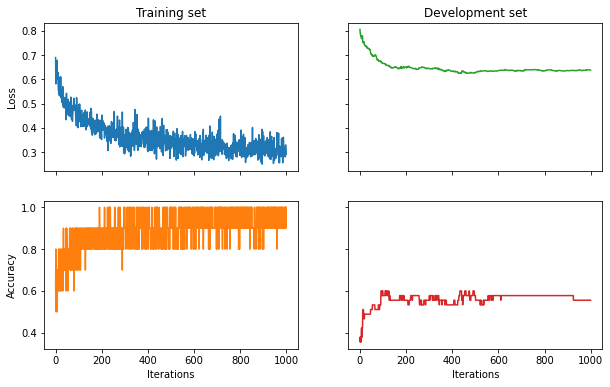

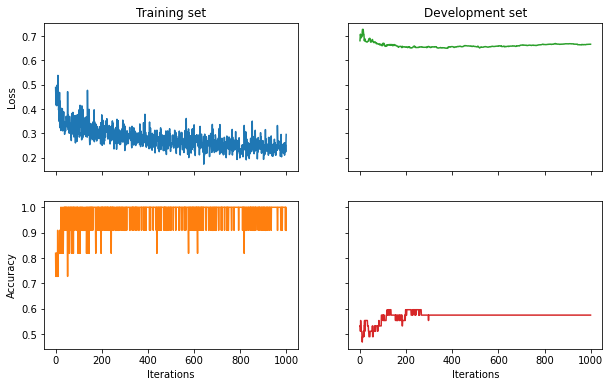

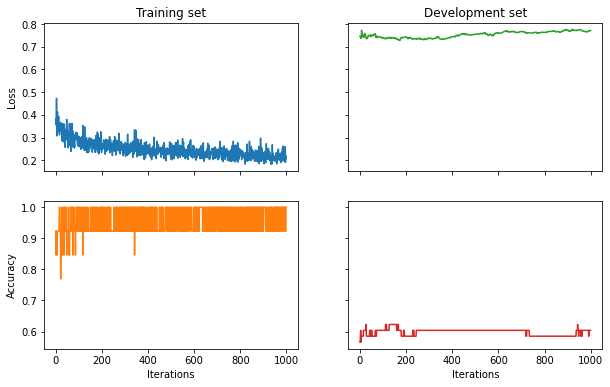

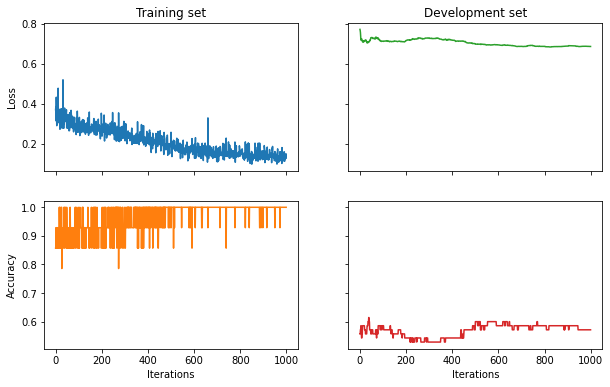

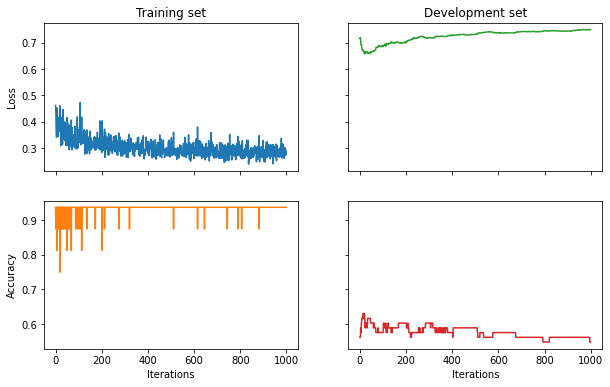

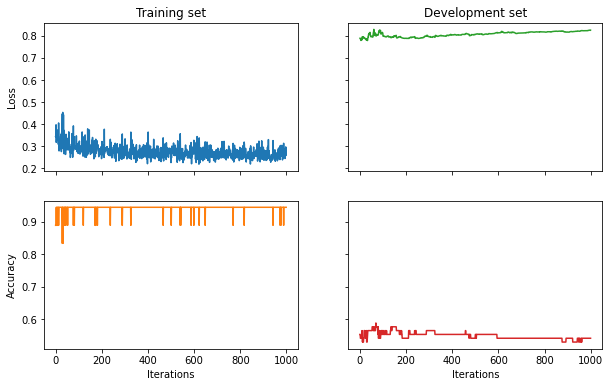

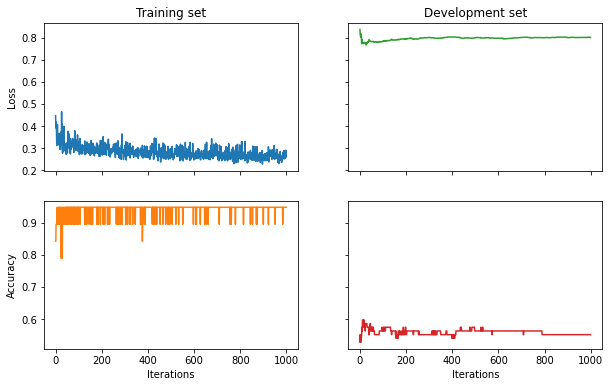

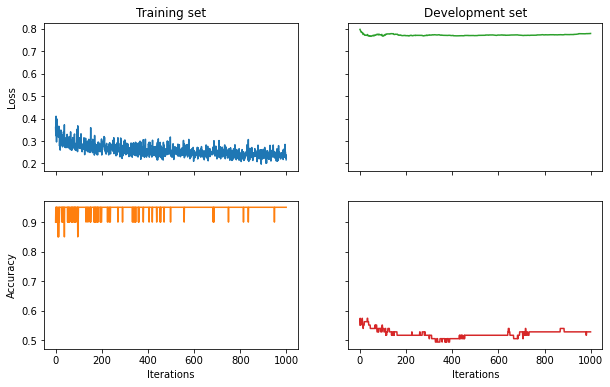

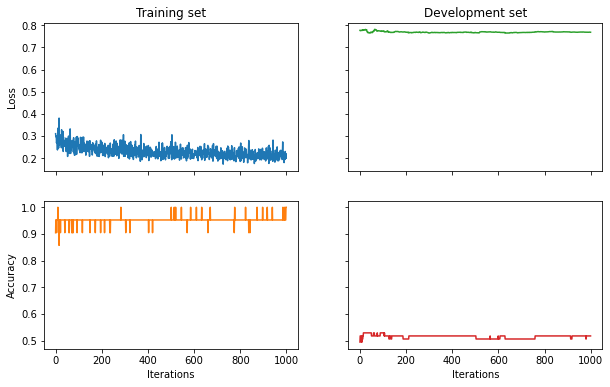

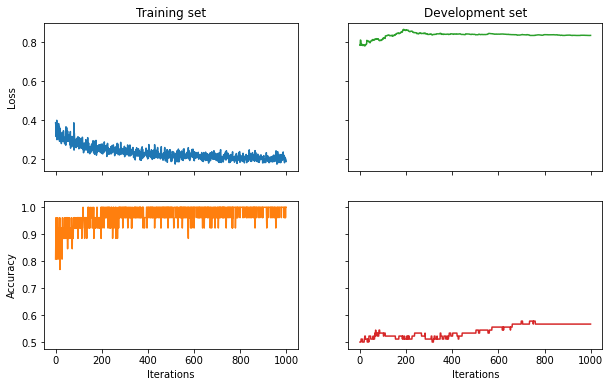

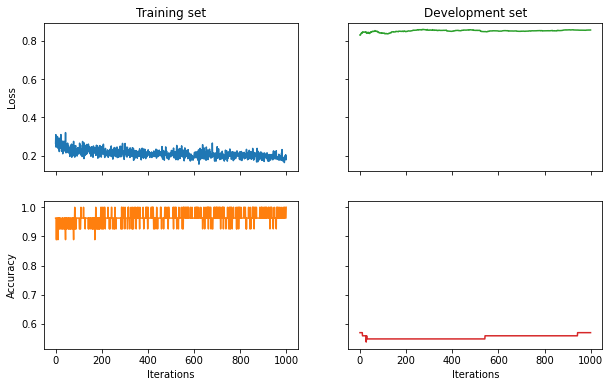

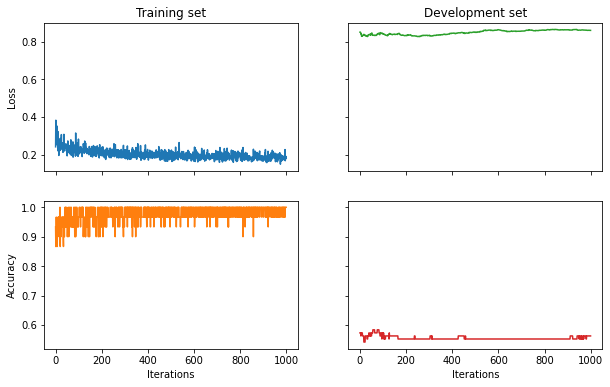

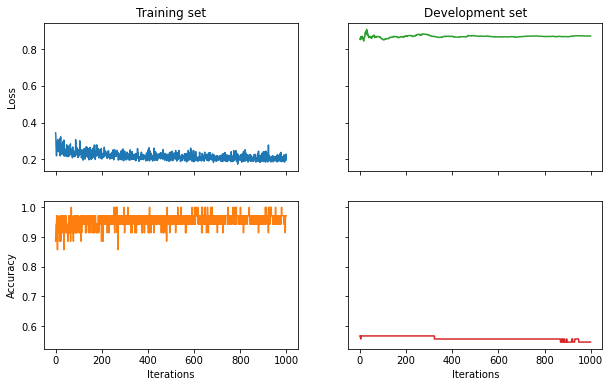

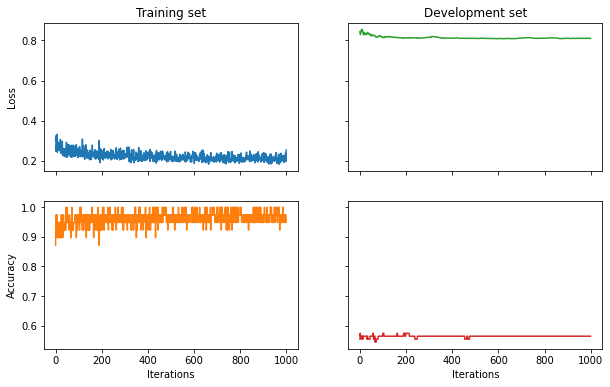

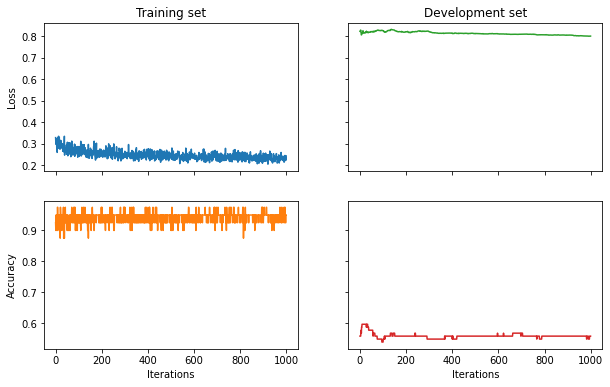

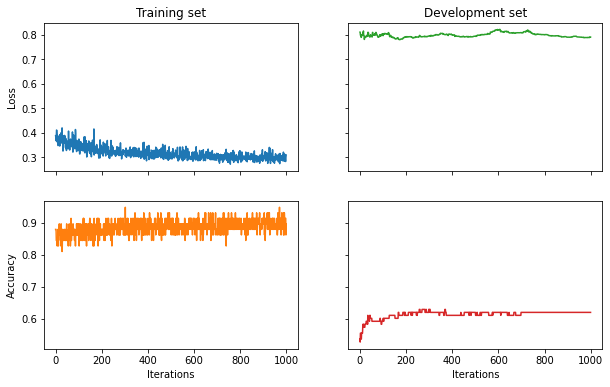

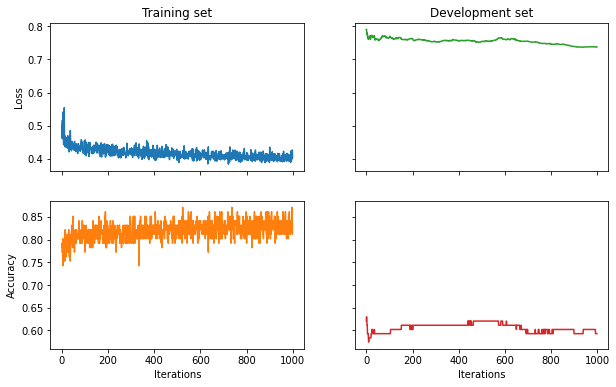

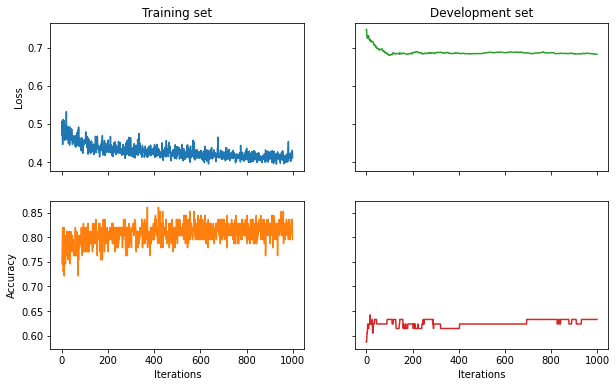

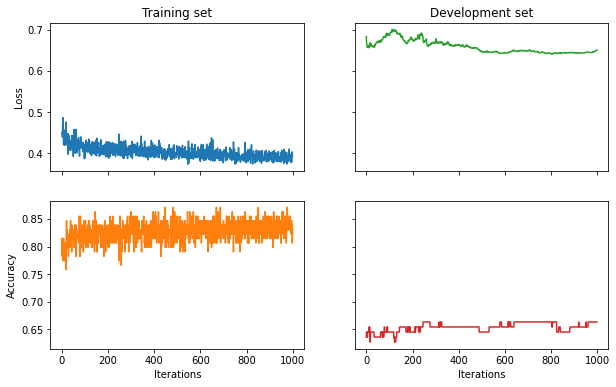

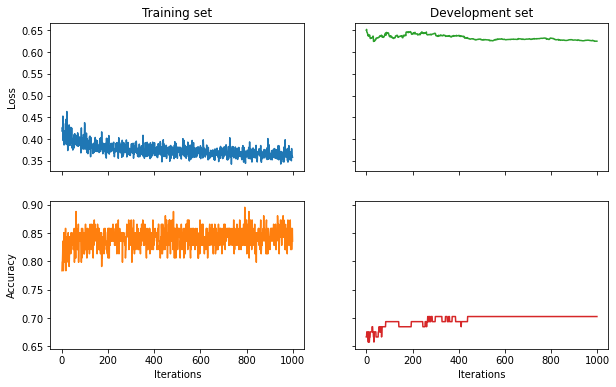

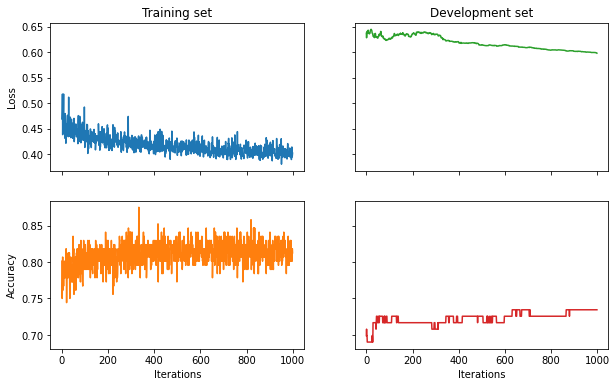

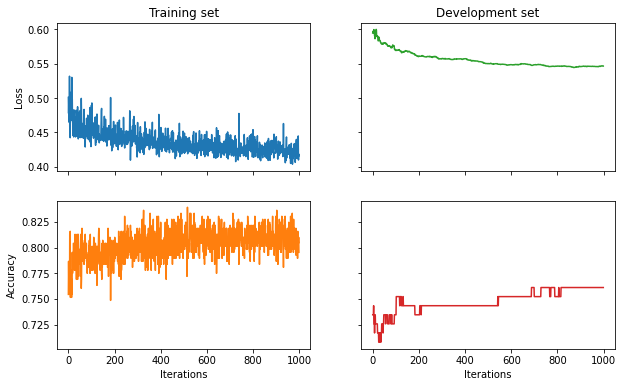

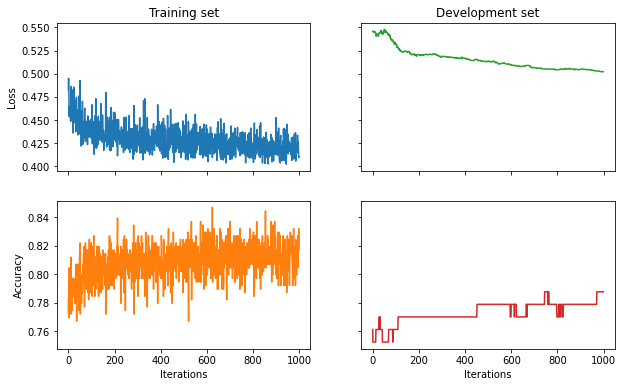

In [8]:
syms = {}
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:10]
current_training_circuits = {}

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
init_params_spsa = np.array(rng.random(len(parameters)))

run = 0
for i, key in enumerate(all_training_keys[10:]):
    print("Progress: ", round((i + 10)/len(all_training_keys), 3))
    
    # Skip cases when the number of parameters did not grow when new circuits were added
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[10:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
            continue
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    #val_test_circ_size = int(0.2*len(current_training_circuits))
    #if len(current_validation_circuits) > val_test_circ_size:
    #    validation_circuits_l = validation_circuits_l[:val_test_circ_size]
    #    validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
    #if len(current_test_circuits) > val_test_circ_size:
    #    test_circuits_l = test_circuits_l[:val_test_circ_size]
    #    test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    print(f"Number of training circuits: {len(training_circuits_l)}   ",
          f"Number of validation circuits: {len(validation_circuits_l)}   ",
          f"Number of test circuits: {len(test_circuits_l)}   ",
          f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}")
    
    train_pred_fn = jit(make_pred_fn(training_circuits_l))
    dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
    test_pred_fn = make_pred_fn(test_circuits_l)
    
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
    
    def callback_fn(xk):
        valid_loss = dev_cost_fn(xk)
        train_loss = round(train_costs[-1], 4)
        train_acc = round(train_accs[-1], 4)
        valid_acc = round(dev_accs[-1], 4)
        iters = int(len(train_accs)/2)
        if iters % 100 == 0:
            print(
                    #f"Params = {xk}, "
                    f"Epoch: {iters}   ",
                    f"train/loss: {train_loss}   ",
                    f"valid/loss: {round(valid_loss, 4)}   ",
                    f"train/acc: {train_acc}   ",
                    f"valid/acc: {valid_acc}", file=sys.stderr
                )
        return valid_loss
        
    result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = 0.0053, c = 0.0185, niter=EPOCHS, callback=callback_fn)
    
    figure_path = this_folder + "//results//" + workload_size + "noisyopt_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params) + "_" + str(run) + ".png"
    visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path)
    run += 1
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)